## SVM Soft-Margin Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt #only used for plotting!!!
%matplotlib inline

from sklearn.datasets import make_blobs #only imported .dataset to generate the dataset, package is not used for anything else!!!

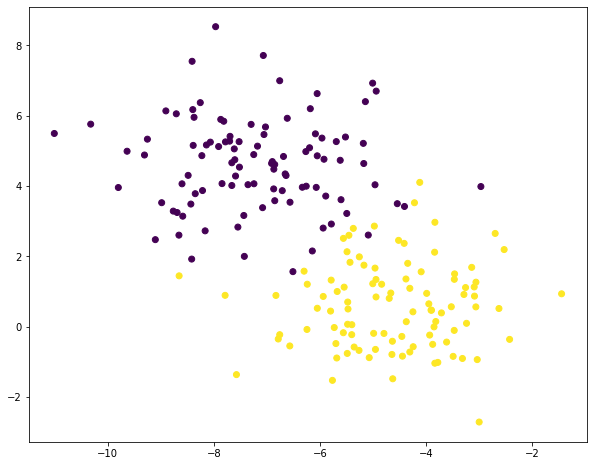

In [2]:
## generate data points
N = 200  # number of samples
D = 2  # number of dimensions
C = 2  # number of classes
seed = 12  # for reproducible experiments
cluster_std = 1.3

alpha_tol = 1e-4 # threshold for choosing support vectors

X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed, cluster_std = cluster_std)
y[y == 0] = -1  # it is more convenient to have {-1, 1} as class labels (instead of {0, 1})
y = y.astype(np.float)
plt.figure(figsize=[10, 8])
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

In [3]:
def linear(x1,x2):
    return np.dot(x1,x2)

In [4]:
from cvxopt import matrix, solvers
class soft_SVM(object):
    def __init__(self, kernel=linear, C=1.0):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y, alpha_tol):
        N, D = X.shape

        #calc outer product of y
        y_tmp = np.zeros((y.shape[0],y.shape[0]))
        for i in range(0,y.shape[0]):
            for j in range(0,y.shape[0]):
                y_tmp[i,j] = y[i]*y[j]

        #calc Gram matrix
        Gram = np.zeros((y.shape[0], y.shape[0]))
        for i in range(0,X.shape[0]):
            for j in range(0,X.shape[0]):
                Gram[i,j] = self.kernel(X[i],X[j])
        
        P = matrix(y_tmp*Gram) #positive defininte matrix which will be minimized
        q = matrix(-np.ones([N, 1])) #np array with ones

        G = matrix(np.vstack((-np.eye(N),np.eye(N))))
        h = matrix(np.hstack((np.zeros(N),np.ones(N)*self.C)))
        
        A = matrix(y.reshape(1,-1))
        b = matrix(np.zeros(1))

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b) #solve the optimization problem
        alphas = np.array(solution['x']).flatten()

        #find support vectors
        support_vecs = (alphas > alpha_tol)

        self.alphas = alphas[support_vecs] #save support vectors
        self.sv = X[support_vecs] #save coordinates of support vectors
        self.sv_y = y[support_vecs] #save labels of support vectors

        #calc weight vector
        w = np.dot(X.T, alphas * y)
        print(f'weights are {w}')

        #calc biases
        biases = y[support_vecs] - np.dot(X[support_vecs, :], w)
        b = np.sum(alphas[support_vecs]*biases) / np.sum(alphas[support_vecs])
        print(f'bias is {b}')

        return alphas, w, b

In [5]:
if __name__ == "__main__":
    def generate_data(N, D, C, seed):
        X, y = make_blobs(n_samples=N, n_features=D, centers=C, random_state=seed, cluster_std=cluster_std)
        y[y == 0] = -1  
        return X, y.astype(np.float)

    def plot_svm(X, y, alpha, w, b, train):
        plt.figure(figsize=[10, 8])
        # Plot the hyperplane
        slope = -w[0] / w[1]
        intercept = -b / w[1]
        x = np.linspace(X[:, 0].min(), X[:, 0].max())
        plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
        plt.plot(x, x * slope + intercept - 1/w[1], 'k--')
        plt.plot(x, x * slope + intercept + 1/w[1], 'k--')
        # Plot all the datapoints
        plt.scatter(X[:, 0], X[:, 1], c=y)
        # Mark the support vectors
        if train == True:
            support_vecs = alpha > alpha_tol
            plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.legend(loc='upper left')

    def run_soft_svm(train):
        sampels, labels = generate_data(N, D, C, seed)
        X_train = sampels[:150]
        X_test = sampels[150:]
        y_train = labels[:150]
        y_test = labels[150:]

        soft_class = soft_SVM()
        alphas, w, b, = soft_class.fit(X_train, y_train, alpha_tol)

        if train == True:
            plot_svm(X_train, y_train, alphas, w, b, train)
        else:
            plot_svm(X_test, y_test, alphas, w, b, train)

weights are [ 0.774197   -1.08415975]
bias is 7.355689692808242
weights are [ 0.774197   -1.08415975]
bias is 7.355689692808242


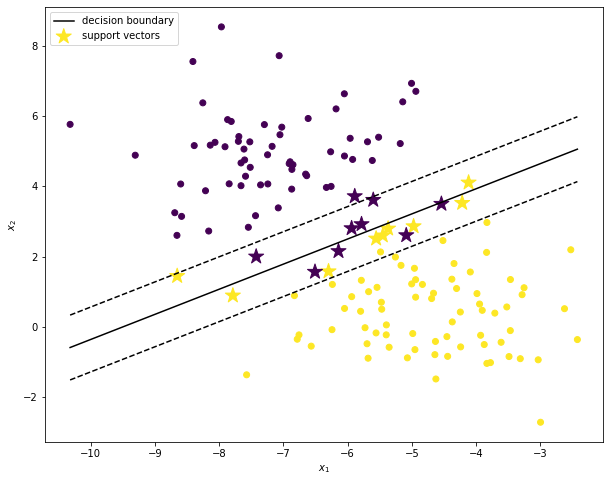

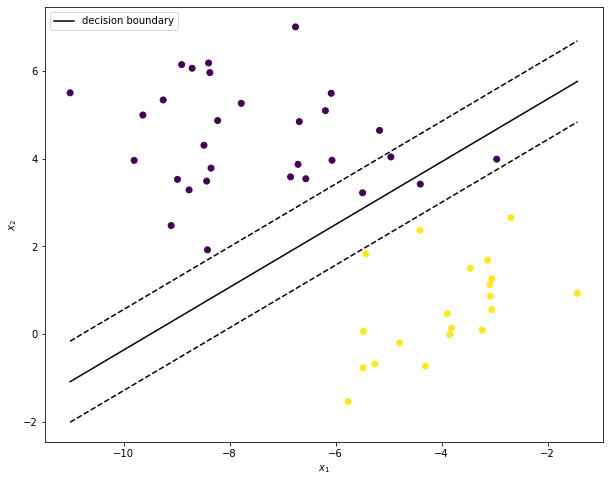

In [6]:
run_soft_svm(True)
run_soft_svm(False)